# Human Thermography Evaluation

This notebook compares two human evaluation techniques presented in the literature, Gonzalez and Keyserlingk scores, against a fully subjective evaluation. 114 thermograms were labeled by two independent researchers -- R1 and R2. 

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis</a></span><ul class="toc-item"><li><span><a href="#Correlation" data-toc-modified-id="Correlation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Correlation</a></span></li><li><span><a href="#Combined-Evaluations" data-toc-modified-id="Combined-Evaluations-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Combined Evaluations</a></span></li><li><span><a href="#Thermal-Scores" data-toc-modified-id="Thermal-Scores-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Thermal Scores</a></span></li></ul></li><li><span><a href="#Score-correlation" data-toc-modified-id="Score-correlation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Score correlation</a></span></li><li><span><a href="#ML" data-toc-modified-id="ML-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>ML</a></span></li></ul></div>

In [3]:
# Import packages
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier as MLP

## Load Data

In [4]:
# Load R1 data
filename = 'r1.csv'
r1 = pd.read_csv(filename)

# Subset evaluation PIDs
eval_pids = r1.ID

# Remove unnecessary columns
r1 = r1.drop(['Idx', 'Imagen', 'Notas', 'ID'], axis = 1) #screening

In [5]:
# Load R2 data
r2 = pd.read_excel('r2.xlsx')

# Preprocess delta-T column and add BIRADS
r2['delta-T'] = [float(string.split("=")[1]) if type(string)==str 
                 else string for string in r2['delta-T'].values]
r2['birads'] = r1['birads']

In [6]:
# Define columns that aren't used in the ML analysis
dropcols = ['BIRADS', 'Subjective', 'Vascularity']

In [7]:
# Rename Columns
r1.columns = ['# Regions of Interest', 'Size of Asymmetry', 
              'Vascularity', 'Shape of Asymmetry', 
              'delta-T', 'Nipple Asymmetry',
              'Breast Shape Asymmetry', 'Subjective', 
              'BIRADS'] 
r2.columns = ['# Regions of Interest', 'Size of Asymmetry', 
              'Vascularity', 'Shape of Asymmetry', 
              'delta-T', 'Nipple Asymmetry',
              'Breast Shape Asymmetry', 'Subjective', 
              'BIRADS'] 

In [8]:
# Show data
r1.head()

,# Regions of Interest,Size of Asymmetry,Vascularity,Shape of Asymmetry,delta-T,Nipple Asymmetry,Breast Shape Asymmetry,Subjective,BIRADS
0,1,4,2,3,1.65,1,2,6,6
1,1,1,1,2,0.69,0,2,2,6
2,1,2,1,3,1.90,0,2,2,2
3,1,2,1,2,3.00,0,2,5,6
4,2,7,4,7,2.20,0,6,9,6


## Analysis
### Correlation 

In [9]:
# Correlation with BIRADS
corr_table1 = r1.corr()
corr_table2 = r2.corr()
corr_table = pd.DataFrame({'R1': corr_table1.BIRADS, 'R2': corr_table2.BIRADS})
corr_table[corr_table.index!='BIRADS']

,R1,R2
# Regions of Interest,0.229216,0.166575
Size of Asymmetry,0.381445,0.099181
Vascularity,0.264944,0.168449
Shape of Asymmetry,0.304006,0.202789
delta-T,0.242897,0.369897
Nipple Asymmetry,-0.010518,0.112920
Breast Shape Asymmetry,0.097229,0.150776
Subjective,0.252105,0.305510


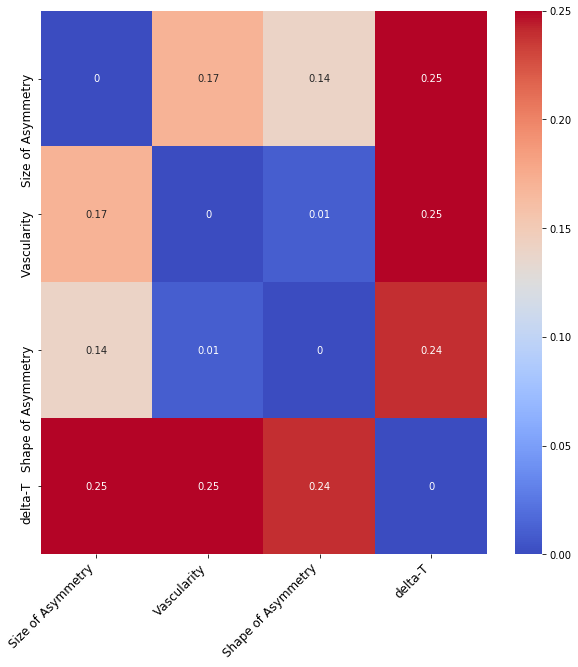

In [10]:
# Difference in feature correlation (Pearson)
diffs = (r1[['Size of Asymmetry', 
             'Vascularity', 
             'Shape of Asymmetry', 
             'delta-T']].corr()-r2[['Size of Asymmetry', 
                                    'Vascularity', 
                                    'Shape of Asymmetry', 
                                    'delta-T']].corr()).round(decimals=2)

# Transform into a heat map
fig = plt.figure(figsize=(10,10))
ax = sns.heatmap(diffs, annot=True, cmap='coolwarm')
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.xlabel("")
plt.ylabel("")
plt.show()

In [11]:
# Check correlation between two tables
table = r1.corrwith(r2, axis=0, method='pearson') #.sort_values(ascending=False)
table = pd.DataFrame(table, columns = ['Pearson'])
table['Spearman'] = r1.corrwith(r2, axis=0, method='spearman').values
table['MeanR1'] = r1.mean(axis=0).values
table['MeanR2'] = r2.mean(axis=0).values
table[table.index!='BIRADS']

,Pearson,Spearman,MeanR1,MeanR2
# Regions of Interest,0.251183,0.259318,0.947368,1.271930
Size of Asymmetry,0.343649,0.332453,2.614035,4.763158
Vascularity,0.274263,0.265181,1.701754,2.903509
Shape of Asymmetry,0.225547,0.212124,3.087719,6.236842
delta-T,0.623705,0.637002,1.371404,1.383421
Nipple Asymmetry,0.116482,0.116482,0.429825,0.736842
Breast Shape Asymmetry,0.241491,0.230806,1.885965,5.114035
Subjective,0.360434,0.380625,3.833333,7.114035


Nipple Asymmetry has the worst Pearson coefficient of around 0.12 (mild correlation.) 

The highest correlation is indicated by the column delta-T - around 0.6. That can be explained by the metric's objective nature. 

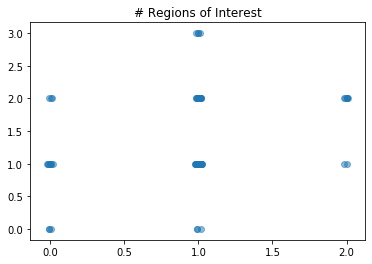

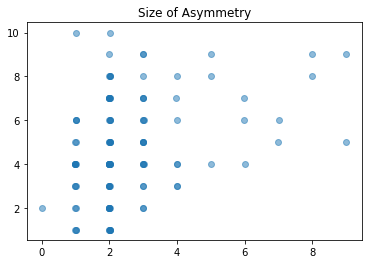

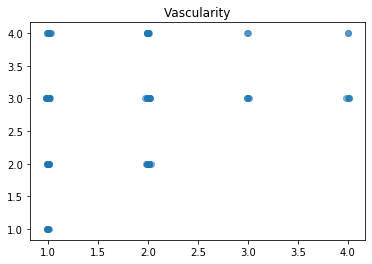

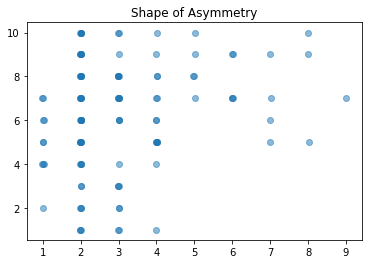

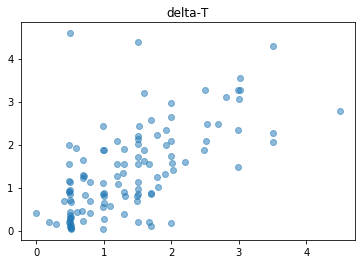

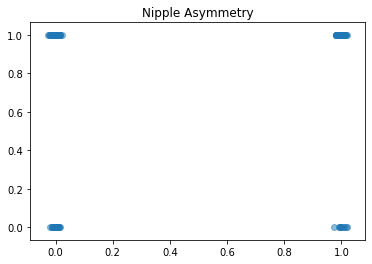

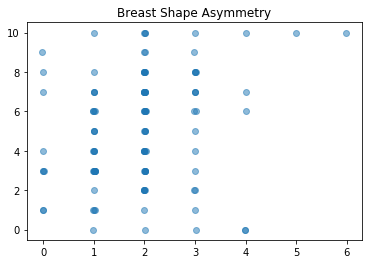

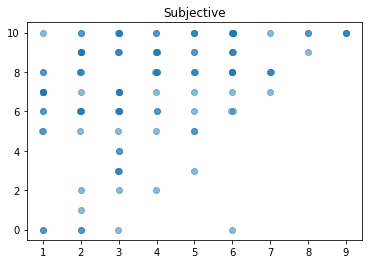

In [12]:
# Exploratory correlation plots for R1 and R2
for column in r1.columns:
    if column != 'BIRADS':
        plt.scatter(r1[column].values + np.random.normal(0,0.01,len(r1)), 
                    r2[column].values, alpha=0.5)
        plt.title(column)
        plt.show()

### Combined Evaluations

In [13]:
# Try both mean or max of R1 and R2 evaluations
comb_avg = r1.copy()
comb_avg_max = r1.copy()
for column in r1.columns:
    comb_avg[column] = (r1[column].values + r2[column].values)/2.
    comb_avg_max[column] = [max(r1[column].values[i], 
                                r2[column].values[i]) for i in range(len(r1[column].values))]

### Thermal Scores

1) Thermal score from Gonzalez (2011): the vascularity score with 4 values plus delta T.

2) VM Score from Keyserlingk (2000) based on the quantity of abnormal signs.

3) Subjective evaluation

In [14]:
def get_therm_scores(r1):
    ''' Create a dataframe with scores and BIRADS statuses. 

    Inputs
    ----------
    r1: pandas dataframe
         Dataframe with human evaluations

    Returns
    -------
    Dataframe with the subjective and Gonzalez scores.
    '''
    # Gonzalez score is defined as the sum of vascularity and delta-T
    scores = pd.DataFrame({'Gonzalez':r1['Vascularity'] + r1['delta-T'],
                           'Subjective': r1['Subjective'],
                           'BIRADS': r1.BIRADS})
    return scores

In [15]:
def hist_feature(feature, df):
    ''' Plot the distribution of scores colored by BI-RADS.
    
    Inputs
    ----------
    feature: str
         Column of interest
    df: pandas dataframe
         Dataframe with all features
    
    Returns
    -------
    Plot of scores colored by BI-RADS.
    '''
    plt.hist(df[feature][df['BIRADS'] == 6], 
             color = 'red',
             alpha = 0.5, 
             density = False)
    plt.hist(df[feature][df['BIRADS'].isin([3,4])], 
             color = 'orange',
             alpha = 0.5, 
             density = False)
    plt.hist(df[feature][df['BIRADS'] <= 2], 
             color = 'blue',
             alpha = 0.5, 
             density = False)
    plt.title(feature)
    plt.show()
    return

In [16]:
# Get thermal scores for both researchers
scores_r1 = get_therm_scores(r1)
scores_r2 = get_therm_scores(r2)
scores_comb_avg = get_therm_scores(comb_avg)
scores_comb_max = get_therm_scores(comb_avg_max)

In [17]:
# This cell extracts the difference between the right and the left breast
# "mean_diff" from the company's database.
pids = np.concatenate([np.load('data/aggregate/pids.npy', 
                               allow_pickle=True), 
                       np.load('data/aggregate/pids_test.npy', 
                               allow_pickle=True),
                       np.load('data/aggregate/pids_blind_test.npy', 
                               allow_pickle=True)])

features = np.concatenate([np.load('data/aggregate/feature_data.npy', 
                                   allow_pickle=True), 
                           np.load('data/aggregate/feature_test.npy', 
                                   allow_pickle=True),
                           np.load('data/aggregate/features_blind_test.npy', 
                                   allow_pickle=True)])

columns = np.load('data/aggregate/feature_names.npy')

# Subset mean_diff required for the VM score
data = pd.DataFrame(features, columns=columns)
data['pids'] = pids
temp_diff = data[['mean_diff', 'pids']]


def add_mean_diff(df, temp_diff, pids):
    ''' Add mean_diff column to human interpretation dataframes. 
    
    Inputs
    ----------
    df: pandas dataframe
         Dataframe with human evaluations
    temp_diff: pandas dataframe
         Dataframe with a feature of interest
    pids: list
         List pf patient IDs

    Returns
    -------
    Dataframe with temp_diff.
    '''
    df_copy = df.copy()
    df_copy['pids'] = pids
    new_df = pd.merge(df_copy, temp_diff, on='pids', how='left')
    # Check for missing values
    new_df[['pids', 'mean_diff']][np.isnan(new_df.mean_diff)]
    return new_df

In [18]:
# Add column to all dfs
new_r1 = add_mean_diff(r1, temp_diff, eval_pids)
new_r2 = add_mean_diff(r2, temp_diff, eval_pids)
new_comb_avg = add_mean_diff(comb_avg, temp_diff, eval_pids)
new_comb_max = add_mean_diff(comb_avg_max, temp_diff, eval_pids)

In [19]:
def get_VM(df):
    ''' 
    Calculate the VM score as defined in Keyserlingk (2000).
    
    Inputs
    ----------
    df: pandas dataframe
         Dataframe with human evaluations
        
    Returns
    -------
    VM score as defined in Keyserlingk (2001)
    '''
    scores = []
    for index, row in df.iterrows():
        if row['Vascularity']<3:
            scores.append(np.ceil(row['Vascularity']))
            continue
        else:
            signs = 0
            # Sign 1: Significant vascular asymmetry
            if row['Vascularity'] > 2:
                signs += 1
            # Sign 2: Unusual vascular shape
            if row['Shape of Asymmetry'] > 5:
                signs+= 1
            # Sign 3: 1 degree increase in temperature
            if row['delta-T'] > 1:
                signs +=1
            # Sign 4: 2 degrees increase
            if row['delta-T'] > 2:
                signs += 1
            # Sign 5: Mean difference above 1.5 degrees
            if row['mean_diff'] > 1.5:
                signs += 1
        if signs == 1:
            scores.append(3)
        elif signs == 2:
            scores.append(4)
        elif signs >= 3:
            scores.append(5)
    return scores

In [20]:
# Add scores to dfs        
scores_r1['Keyserlingk'] = get_VM(new_r1)
scores_r2['Keyserlingk'] = get_VM(new_r2)
scores_comb_avg['Keyserlingk'] = get_VM(new_comb_avg)
scores_comb_max['Keyserlingk'] = get_VM(new_comb_max)

## Score correlation

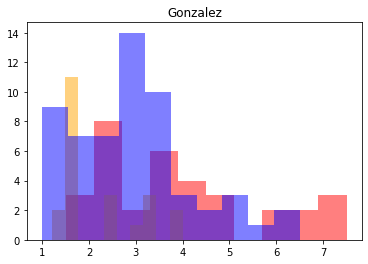

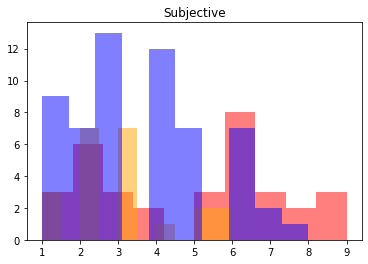

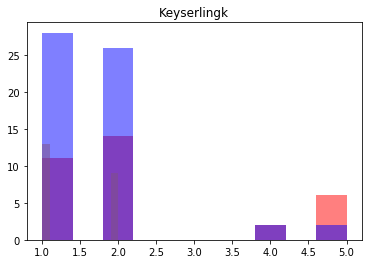

In [21]:
# Plot thermal scores
therm_plot = [hist_feature(ts, scores_r1) for ts in ['Gonzalez', 
                                                     'Subjective',
                                                     'Keyserlingk']]

In [22]:
# Print correlation scores with BIRADS
score_table = scores_r1.corr().BIRADS
score_table = pd.DataFrame(score_table)
score_table.columns = ['R1']
score_table['R2'] =  scores_r2.corr().BIRADS.values
score_table['Both Mean'] =  scores_comb_avg.corr().BIRADS.values
score_table['Both Max'] =  scores_comb_max.corr().BIRADS.values
score_table
to_print = score_table[(score_table.index!='BIRADS')]
to_print.index = ['Gonzalez', 'Subjective', 'Keyserlingk']
to_print

,R1,R2,Both Mean,Both Max
Gonzalez,0.290213,0.351429,0.361505,0.355754
Subjective,0.252105,0.305510,0.340971,0.366800
Keyserlingk,0.250293,0.315799,0.231851,0.315367


The performance is comparable for both researchers, none of the scores seem to be significantly better than the other, but the Gonzalez score is the leader for the full dataset. 

In [23]:
# Adapted from:
# https://stackoverflow.com/questions/28719067/roc-curve-and-cut-off-point-python
def find_threshold(target, pred, vis=False):
    """ Find the optimal threshold by maximizing specificity + sensitivity
    
    Inputs
    ----------
    target : pandas dataframe
        Matrix with target data, where rows are observations

    pred : pandas dataframe
        Matrix with predicted data, where rows are observations
    vis: bool (optional)
        Indicator of whether to create a visualization
    
    Returns
    -------     
    List type, with optimal cutoff value

    """
    fpr, tpr, threshold = metrics.roc_curve(target, pred)
    i = np.arange(len(tpr)) 
    if vis:
        roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),
                                'tpr' : pd.Series(tpr, index = i), 
                                '1-fpr' : pd.Series(1-fpr, index = i), 
                                'tf' : pd.Series(tpr - (1-fpr), index = i), 
                                'thresholds' : pd.Series(threshold, index = i)})
        roc.ix[(roc.tf-0).abs().argsort()[:1]]

        # Plot tpr vs 1-fpr
        fig, ax = plt.subplots()
        plt.plot(roc['tpr'])
        plt.plot(roc['1-fpr'], color = 'red')
        plt.xlabel('1-False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Optimal Intersection')
        ax.set_xticklabels([])
        plt.show()
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]
    return float(roc_t['threshold']) 

In [41]:
# Explore the best thresholds
def get_ROC(df, vis=False):
    ''' Compute ROC scores for two researchers. 
    
    Inputs
    ----------
    df : pandas dataframe 
        Dataframe with scores

    vis : bool 
        Indicator of whether to produce plots

    Returns
    -------     
    Plt type, ROC curves for different scores
    '''
    scores = df.copy()
    # Turn BIRADS into binary cancer column
    scores['cancer'] = np.where(scores['BIRADS']>3, 1,0)
    scores = scores.drop(columns='BIRADS')
    gt = scores.cancer.values
    # Normalize features
    x = scores.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    scores = pd.DataFrame(x_scaled, columns=scores.columns)
    labels = ['Gonzalez', 'Keyserlingk', 'Subjective']
    i=-1
    for column in scores.columns:
        # Define which scores to include
        if column != 'cancer' :
            fpr, tpr, thresholds = metrics.roc_curve(gt, scores[column].values)
            thres = find_threshold(gt, scores[column].values, vis=False)
            print(str(column) +' optimal threshold: {0:0.2}'.format(thres))
            if vis:
                i+=1
                auc_score = str(round(metrics.roc_auc_score(gt, scores[column].values), 2))
                plt.plot(fpr,tpr, label=labels[i] + ' AUC: ' + auc_score)
                plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate') 
        plt.legend()
        plt.plot()
    return gt, scores

Gonzalez optimal threshold: 0.31
Subjective optimal threshold: 0.38
Keyserlingk optimal threshold: 0.25


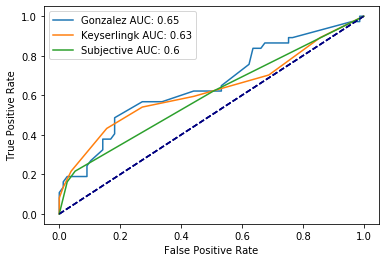

In [42]:
# Compare performance
gt, preds = get_ROC(scores_comb_avg, True)

In [44]:
pred_df = pd.DataFrame({'pid':eval_pids, 'gt': gt, 
                        'preds': preds['Gonzalez'].values})
pred_df.to_csv('human_predictions.csv')

## ML

Even though this part is not included in the paper, the graphs illustrate that it is possible to differentiate between different BIRADS groups using ML models. This analysis is beyond the scope of this paper but might be useful in case more manually scored data will be added to the pipeline.

In [26]:
# Subset train and test sets
test_ind = np.random.rand(len(r1)) > 0.7
train = r1[~test_ind]
test = r1[test_ind]

In [27]:
# Train different models
mlp = MLP(hidden_layer_sizes = (5))
logreg = LogisticRegression()
rf = RandomForestClassifier()

mlp.fit(train.drop(dropcols, axis=1), 
        train['BIRADS']==6)
logreg.fit(train.drop(dropcols, axis=1),
           train['BIRADS']==6)
rf_model = rf.fit(train.drop(dropcols, axis=1),
                  train['BIRADS']==6)

In [28]:
# Create a copy of test to get predictions
# We need it because we add new columns to test
test_copy = test.drop(dropcols, axis=1)

In [29]:
test['preds_mlp'] = mlp.predict_proba(test_copy)[:,1]
test['preds_lr'] = logreg.predict_proba(test_copy)[:,1]
test['preds_rf'] = rf.predict_proba(test_copy)[:,1]

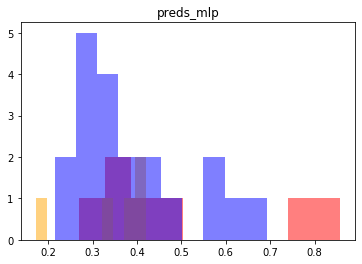

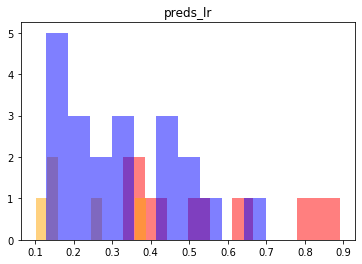

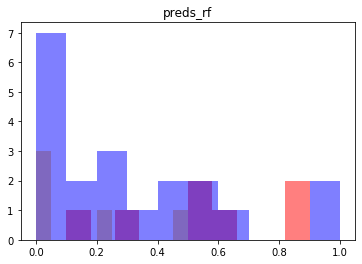

In [30]:
preds = [hist_feature(preds, test) for preds in ['preds_mlp', 'preds_lr','preds_rf']]